
    Yudha Cipta M. Y.
    Hacktiv8 - Batch 01

#### introduction
The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:
- Single-image, multi-class classification problem
- More than 40 classes
- More than 50,000 images in total
- Large, lifelike database


_Source_ : This dataset originally imported from kaggle: https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign.


_Objective_ : In this project, I will use Convolutional Neural Network to build train and test a traffic sign classification model using tensorflow and keras.

***
### Import library

In [35]:
#Importlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image

from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import random
%matplotlib inline

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data Loading & Cleaning

In [4]:
# get the dataset by downloading directly from kaggle using kaggle API client.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ycmy28","key":"16708e4fa60899711324fdc9ab0b37c7"}'}

In [5]:
!pip install -q kaggle

In [6]:
# Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# creating directory and changing the current working directory
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset/traffic_sign_dataset


To store the data I will create a new directory and make it as current working directory.

In [8]:
# searching dataset traffic sign
!kaggle datasets list -s gtsrb-german-traffic-sign

ref                                                                title                                               size  lastUpdated          downloadCount  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34          37551  
valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11           6338  
eunjurho/german-traffic-sign-recognition-benchmark-cropped         german_traffic_sign_recognition_benchmark_cropped  206MB  2019-11-10 15:22:13            203  
valentynsichkar/preprocessed-light-version-of-traffic-signs        Pre-processed Light version of Traffic Signs         8GB  2021-04-10 13:35:24             15  
valentynsichkar/traffic-sign

In [9]:
# downloading dataset and coming out of directory
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign  
%cd ..

 99% 605M/612M [00:04<00:00, 176MB/s]
100% 612M/612M [00:04<00:00, 145MB/s]
/content/traffic_sign_dataset


In [10]:
# unzipping downloaded file and removing unusable file
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip
!rm -rf traffic_sign_dataset/Meta
!rm -rf traffic_sign_dataset/meta
!rm -rf traffic_sign_dataset/test
!rm -rf traffic_sign_dataset/train
!rm traffic_sign_dataset/Meta.csv

Streaming output truncated to the last 5000 lines.
  inflating: traffic_sign_dataset/train/5/00005_00053_00010.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00011.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00012.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00013.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00014.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00015.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00016.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00017.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00018.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00019.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00020.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00021.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00022.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00023.png  
  inflating: traffic_sign

### Data Exploration & Preprocessing

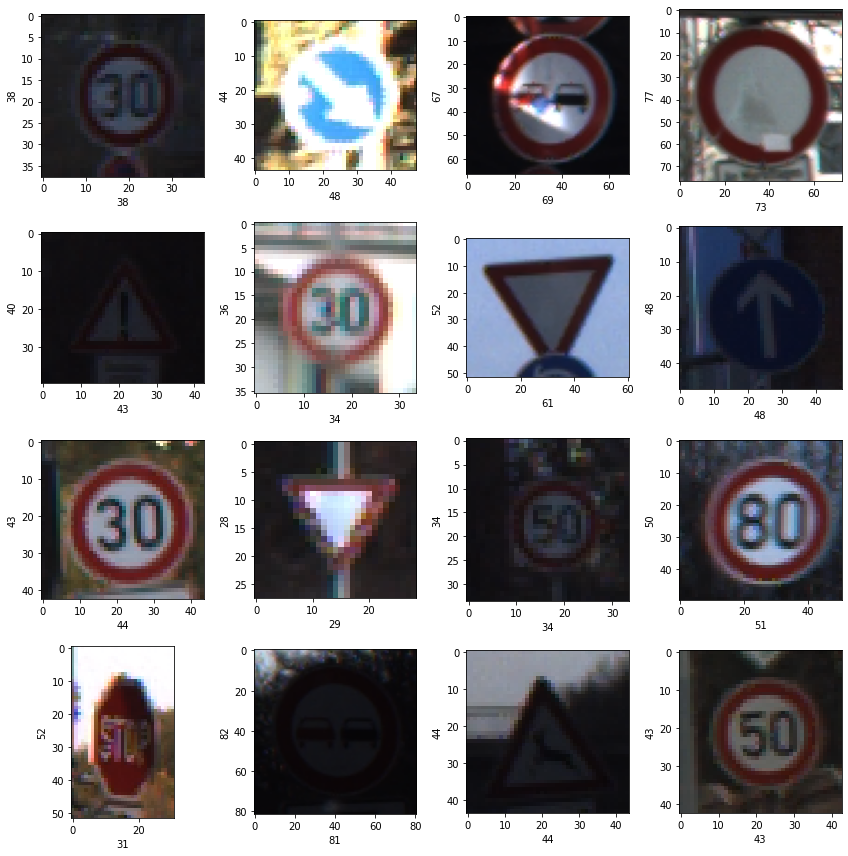

In [11]:
# plotting images to check dataset
plt.figure(figsize=(12,12))
path = "traffic_sign_dataset/Test"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

after visualizing some images of traffic sign from the dataset, we can see the dimension of images are uneven and need to make them even/equal first.

In [12]:
#the mean of dimension will be taken as parameter to resize the img while building the pipeline
dim1 = []
dim2 = []

for i in range(0,43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

the images of the same dimension will be needed for further prerprocessing data, so all of the images from training dataset will be stored first from all 43 classes.

In [13]:
print("Dimension 1 Mean : ",np.mean(dim1), " Dimension 2 Mean : ",np.mean(dim2))

Dimension 1 Mean :  50.328929582493814  Dimension 2 Mean :  50.83587951745773


we can see that (50,50) is the average shape for all the images.

In [14]:
#reshape the images to (50,50)
images = []
label_id = []

for i in range(43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = Image.open(labels + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)
        label_id.append(i)

Now we will reshape the images into (50,50) and also store their label id. Next convert the image into numpy array and normalize them.

In [15]:
#converting images into numpy array
images = np.array(images)
#the pixel value of each image ranges between 0 and 255, normalization by dividing each image by 255 will scale the values between 0 and 1.
images = images/255 

In [16]:
label_id = np.array(label_id)
label_id.shape

(39209,)

In [17]:
images.shape

(39209, 50, 50, 3)

Checking the shape of the images. Here we can see that their are 39209 images with a shape of (50,50,3.)

In [18]:
#visualize the number of classes count, see if the data is balance or not
label_counts = pd.DataFrame(label_id).value_counts()
label_counts.head()

2     2250
1     2220
13    2160
12    2100
38    2070
dtype: int64

From the result we can say that data is balanced.

### Model Definition and Training


_split data into train&validation with 80:20 ratio_

In [19]:
#Splitting the data again into train and validation
x_train, x_val, y_train, y_val = train_test_split(images, label_id , test_size = 0.2, random_state = 42)

converting the classes column into categorical using to_categorical() function. (one hot encoding on keras)

In [20]:
#one-hot encoding.
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [21]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax'))

In [22]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0

compile built up model using metrics, optimizer and loss as required also printing out the summary of the model.

In [23]:
model.fit(x_train, y_train, epochs = 10, batch_size = 125, validation_data = (x_val, y_val), verbose = 2)

Epoch 1/10
251/251 - 20s - loss: 2.6610 - accuracy: 0.2801 - val_loss: 1.4424 - val_accuracy: 0.6100
Epoch 2/10
251/251 - 3s - loss: 1.3062 - accuracy: 0.5927 - val_loss: 0.5826 - val_accuracy: 0.8632
Epoch 3/10
251/251 - 3s - loss: 0.8261 - accuracy: 0.7317 - val_loss: 0.3249 - val_accuracy: 0.9286
Epoch 4/10
251/251 - 3s - loss: 0.6364 - accuracy: 0.7956 - val_loss: 0.2275 - val_accuracy: 0.9569
Epoch 5/10
251/251 - 3s - loss: 0.5270 - accuracy: 0.8288 - val_loss: 0.1767 - val_accuracy: 0.9640
Epoch 6/10
251/251 - 3s - loss: 0.4648 - accuracy: 0.8470 - val_loss: 0.1460 - val_accuracy: 0.9737
Epoch 7/10
251/251 - 3s - loss: 0.4096 - accuracy: 0.8652 - val_loss: 0.1204 - val_accuracy: 0.9786
Epoch 8/10
251/251 - 3s - loss: 0.3855 - accuracy: 0.8759 - val_loss: 0.0934 - val_accuracy: 0.9778
Epoch 9/10
251/251 - 3s - loss: 0.3474 - accuracy: 0.8857 - val_loss: 0.0841 - val_accuracy: 0.9824
Epoch 10/10
251/251 - 3s - loss: 0.3273 - accuracy: 0.8951 - val_loss: 0.0817 - val_accuracy: 0.982

### Model Evaluation

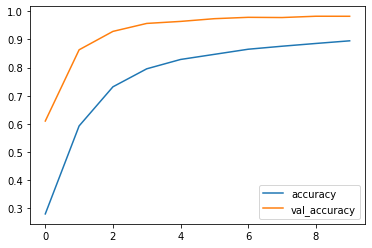

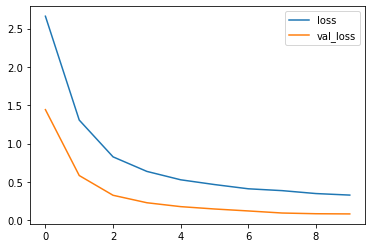

In [24]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

In [25]:
#test_evaluate = model.evaluate(val_dataset)
test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)

246/246 - 1s - loss: 0.0817 - accuracy: 0.9823


In [26]:
%time model.evaluate(x_val, y_val)

246/246 [==============================] - 1s 3ms/step - loss: 0.0817 - accuracy: 0.9823
CPU times: user 1.12 s, sys: 270 ms, total: 1.39 s
Wall time: 1.01 s


[0.08172118663787842, 0.9822749495506287]

In [27]:
pred_train = model.predict(x_train)
scores = model.evaluate(x_train, y_train)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))

981/981 [==============================] - 3s 3ms/step - loss: 0.0609 - accuracy: 0.9909
Accuracy on training data: 0.990882158279419% 
 Error on training data: 0.009117841720581055


In [28]:
pred_val = model.predict(x_val)
scores = model.evaluate(x_val, y_val)
print('Accuracy on validation data: {}% \n Error on validation data: {}'.format(scores[1], 1 - scores[1]))

246/246 [==============================] - 1s 3ms/step - loss: 0.0817 - accuracy: 0.9823
Accuracy on validation data: 0.9822749495506287% 
 Error on validation data: 0.017725050449371338


### Model improvement

In [37]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
epochs = 30
learning_rate=0.001

In [38]:
model.compile(loss = 'sparse_categorical_crossentropy', 
             optimizer=keras.optimizers.Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5)), 
              metrics = ['accuracy'])

In [40]:
pred_val = model.predict(x_val)
scores = model.evaluate(x_val, y_val)
print('Accuracy on testing data: {}% \n Error on testing data: {}'.format(scores[1], 1 - scores[1]))

246/246 [==============================] - 1s 3ms/step - loss: 0.0817 - accuracy: 0.0045
Accuracy on testing data: 0.00446314737200737% 
 Error on testing data: 0.9955368526279926


In [41]:
%time model.evaluate(x_val, y_val)

246/246 [==============================] - 1s 3ms/step - loss: 0.0817 - accuracy: 0.0045
CPU times: user 1.22 s, sys: 140 ms, total: 1.36 s
Wall time: 1.07 s


[0.08172118663787842, 0.00446314737200737]

### Model Inference

_loading dataset_

In [42]:
#create path test dataset and remove file that cant be processed
test_path = 'traffic_sign_dataset/Test'
!rm traffic_sign_dataset/Test/GT-final_test.csv

scaling image, but now with a function

In [43]:
#scale images with a function
from PIL import Image

def scaling(test_images, test_path):
    images = []

    image_path = test_images
    
    for x in image_path:
        img = Image.open(test_path + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)

    #converting images into numpy array
    images = np.array(images)
    #normalization.
    images = images/255

    return images

In [44]:
test_images = scaling(sorted(os.listdir(test_path)),test_path)

In [45]:
test = pd.read_csv('traffic_sign_dataset/Test.csv')
y_test = test['ClassId'].values
y_test

array([16,  1, 38, ...,  6,  7, 10])

In [46]:
test

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  int64 
 1   Height   12630 non-null  int64 
 2   Roi.X1   12630 non-null  int64 
 3   Roi.Y1   12630 non-null  int64 
 4   Roi.X2   12630 non-null  int64 
 5   Roi.Y2   12630 non-null  int64 
 6   ClassId  12630 non-null  int64 
 7   Path     12630 non-null  object
dtypes: int64(7), object(1)
memory usage: 789.5+ KB


In [48]:
test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [49]:
predict_x=model.predict(test_images) 
classes_x=np.argmax(predict_x,axis=1)

In [50]:
print(classification_report(y_test, classes_x))

              precision    recall  f1-score   support

           0       1.00      0.62      0.76        60
           1       0.97      0.95      0.96       720
           2       0.94      0.98      0.96       750
           3       0.97      0.90      0.94       450
           4       0.97      0.95      0.96       660
           5       0.83      0.95      0.89       630
           6       0.99      0.71      0.82       150
           7       0.92      0.88      0.90       450
           8       0.91      0.87      0.89       450
           9       0.97      0.99      0.98       480
          10       0.98      0.99      0.99       660
          11       0.94      0.98      0.96       420
          12       0.99      0.99      0.99       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       0.99      0.97      0.98       150
          17       1.00    

In [51]:
#storing all lables
all_lables = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']

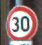

In [52]:
#visualize test image
img = Image.open(test_path + '/00001.png')
img

In [53]:
#original label
print("Original label : ",all_lables[y_test[1]])

Original label :  Speed limit (30km/h)


In [55]:
#predicted label
print("Predicted label : ",all_lables[classes_x[1]])

Predicted label :  Speed limit (30km/h)


## Conclusion:

After started with downloading the dataset, preprocessing, created the model and testing the predictions using the model, we found that this dataset has 43 classes. The model that ive been created got an accuracy of 95%+ from 30 epochs, could be optimize further with hyper parameter tuning and reach a higher accuracy. 

In [79]:
print('Test Data accuracy: ',accuracy_score(y_test, classes_x)*100)

Test Data accuracy:  94.53681710213777


### Model Improvement using augmentation

In [80]:
model2 = Sequential()

model2.add(Conv2D(filters = 65, kernel_size = (3,3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(filters = 65, kernel_size = (3,3), activation = 'relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(Dense(130, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(43, activation = 'softmax'))

In [81]:
epochs=30

In [82]:
model2.compile(loss= 'sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001, decay=learning_rate / (epochs * 0.5)),
              metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 65)        1820      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 65)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 65)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 65)        38090     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 65)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 65)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7865)              0

In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

keras.backend.clear_session()

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history2 = model2.fit(aug.flow(x_train, y_train, batch_size=128), epochs=20, 
                    validation_data=(x_val, y_val))

Epoch 1/20
246/246 [==============================] - 24s 94ms/step - loss: 2.9832 - accuracy: 0.1941 - val_loss: 1.9799 - val_accuracy: 0.4260
Epoch 2/20
246/246 [==============================] - 23s 92ms/step - loss: 2.0629 - accuracy: 0.3724 - val_loss: 1.3783 - val_accuracy: 0.5826
Epoch 3/20
246/246 [==============================] - 23s 92ms/step - loss: 1.6676 - accuracy: 0.4653 - val_loss: 1.0615 - val_accuracy: 0.6701
Epoch 4/20
246/246 [==============================] - 23s 92ms/step - loss: 1.4475 - accuracy: 0.5229 - val_loss: 0.8693 - val_accuracy: 0.7633
Epoch 5/20
246/246 [==============================] - 23s 92ms/step - loss: 1.3098 - accuracy: 0.5667 - val_loss: 0.7233 - val_accuracy: 0.7939
Epoch 6/20
246/246 [==============================] - 23s 93ms/step - loss: 1.2041 - accuracy: 0.6001 - val_loss: 0.6132 - val_accuracy: 0.8226
Epoch 7/20
246/246 [==============================] - 23s 92ms/step - loss: 1.1271 - accuracy: 0.6208 - val_loss: 0.5384 - val_accuracy:

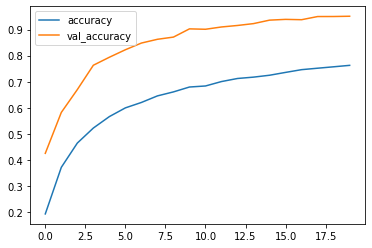

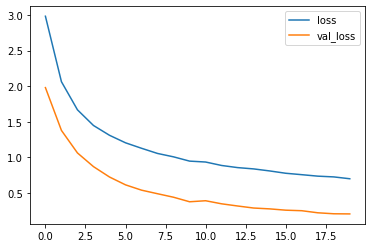

In [84]:
evaluation2 = pd.DataFrame(model2.history.history)
evaluation2[['accuracy', 'val_accuracy']].plot()
evaluation2[['loss', 'val_loss']].plot()

In [85]:
predict2_x=model2.predict(test_images) 
classes2_x=np.argmax(predict2_x,axis=1)

In [86]:
print('Test Data accuracy: ',accuracy_score(y_test, classes2_x)*100)

Test Data accuracy:  88.33729216152018


### Conclusion

After try to improve with a new model by using augmentation, the result is quite disappointing, perhaps with a better tuning we can have a better result too. A better understanding with the model metrics and literature study in augmentation will help to increase the result.


the last model we create have been succesfully meet my expectation for now, with more than 50k images in total to train and 43 classes the model can predict with good accuracy.